<a href="https://colab.research.google.com/github/zeng-zr/FacePerceptionProject/blob/main/load_ECoG_faceshouses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Miller ECoG data of faces/houses (+ noise)

includes some visualizations

In [102]:
# @title Data retrieval
import os, requests

fname = 'faceshouses.npz'
url = "https://osf.io/argh7/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [103]:
# @title Install packages (`nilearn`, `nimare`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [104]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here.
#dat1 = alldat[1][0]#没有key_press
#dat2 = alldat[1][1]
dat1=alldat[3][0]
dat2=alldat[3][1]
print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['stim_id', 'stim_cat', 'stim_noise', 't_on', 't_off', 'key_press', 'V', 'categories', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [105]:
print(dat2['key_press'].shape)

(141,)


## Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. We plan to curate a few more before NMA starts. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`alldat` contains 7 subjects each with two sessions `dat1` and `dat2`, and was originally used in these publications:

*Miller, Kai J., et al. "Face percept formation in human ventral temporal cortex." Journal of neurophysiology 118.5 (2017): 2614-2627.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

In this task, subjects in a clinical settings (with ECoG implants) are passively shown faces and house during the first experiment (`dat1`). Then in the second experiment in the same subjects (`dat2`), noise is added to face and houses images and the subject has to detect the faces by pressing a key. Two of the subjects don't have keypresses.

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size.

Experiment 1:
* `dat1['V']`: continuous voltage data (time by channels)
* `dat1['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat1['t_on']`: time of stimulus onset in data samples
* `dat1['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat1['stim_id`]: identity of stimulus from 1-100, with 1-50 being houses and 51-100 being faces
* `dat1['locs`]: 3D electrode positions on the brain surface

Experiment 2:
* `dat2['V`]: continuous voltage data (time by channels)
* `dat2['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat2['t_on']`: time of stimulus onset in data samples
* `dat2['t_off']`: time of stimulus offset, always 1000 samples after `t_on`, with no inter-stimulus interval
* `dat2['stim_id`]: identity of stimulus from 1-600 (not really useful, since we don't know which ones are the same house/face)
* `dat2['stim_cat']`: stimulus category (1 = house, 2 = face)
* `dat2['stim_noise']`: percent noise from 0 to 100
* `dat2['key_press']`: when the subject thought the image was a face
* `dat2['categories']`: categories legend (1 = house, 2 = face)
* `dat2['locs`]: 3D electrode positions on the brain surface


In [127]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)

view

<Figure size 800x800 with 0 Axes>

## dat1

In [107]:
# quick way to get broadband power in time-varying windows
from scipy import signal

V = dat1['V'].astype('float32')

b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

V = V/V.mean(0)

In [108]:
# average the broadband power across all face stimuli and across all house stimuli

nt, nchan = V.shape
nstim = len(dat1['t_on'])
trange = np.arange(-200, 400)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 600, nchan))

V_house = (V_epochs[dat1['stim_id'] <= 50]).mean(0)

V_face = (V_epochs[dat1['stim_id'] > 50]).mean(0)

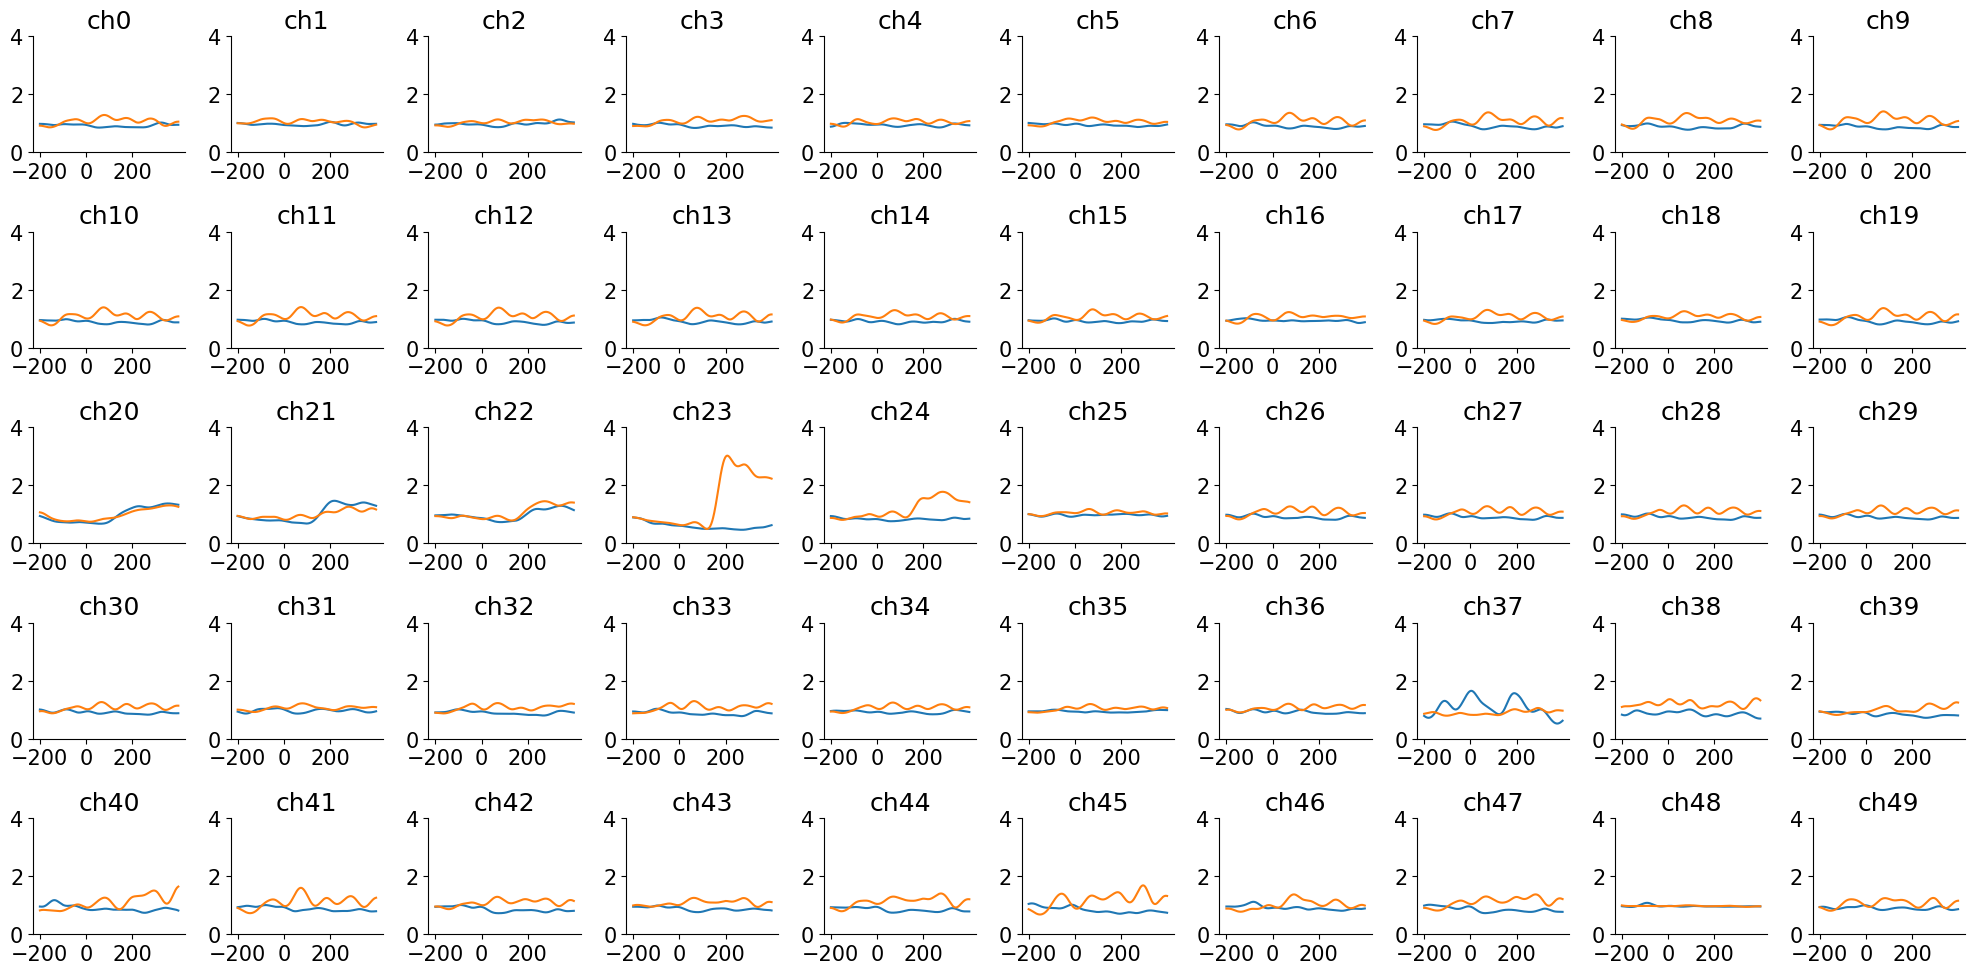

In [109]:
# let's find the electrodes that distinguish faces from houses
plt.figure(figsize=(20, 10))
for j in range(50):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_house[:, j])
  plt.plot(trange, V_face[:, j])
  plt.title('ch%d'%j)
  plt.xticks([-200, 0, 200])
  plt.ylim([0, 4])
plt.show()

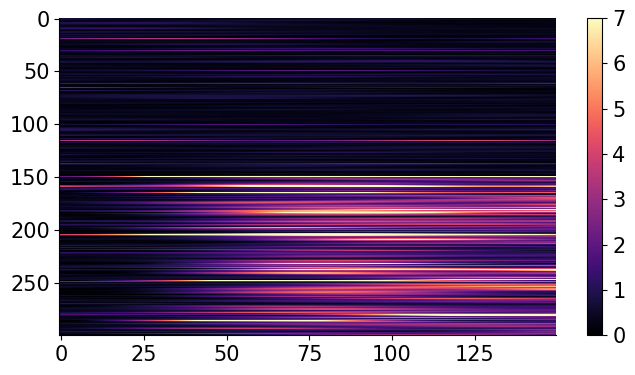

In [123]:
# let's look at all the face trials for electrode 23 that has a good response to faces
# we will sort trials by stimulus id (1-50 is houses, 51-100 is faces)
plt.subplot(1, 3, 1)
isort = np.argsort(dat1['stim_id'])

plt.imshow(V_epochs[isort, :, 23].astype('float32'),
           aspect='auto', vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

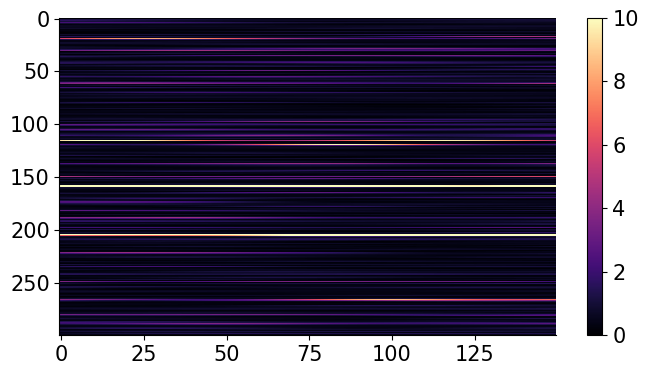

In [132]:
# Electrode 43 seems to respond to houses
isort = np.argsort(dat1['stim_id'])
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[isort, :, 43].astype('float32'),
           aspect='auto', vmax=10, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

## Step 1 right time period for analyses


In [133]:
#只需修改trange即可
nt, nchan = V.shape
nstim = len(dat1['t_on'])

#trange = np.arange(-200, 400)
trange = np.arange(120, 270)
trange_set= np.arange(trange[0],trange[-1]+1,step=15)
tlen=len(trange)
ts = dat1['t_on'][:, np.newaxis] + trange
#V_epochs = np.reshape(V[ts, :], (nstim, 600, nchan))
V_epochs = np.reshape(V[ts, :], (nstim, tlen, nchan))

V_house = (V_epochs[dat1['stim_id'] <= 50]).mean(0)

V_face = (V_epochs[dat1['stim_id'] > 50]).mean(0)



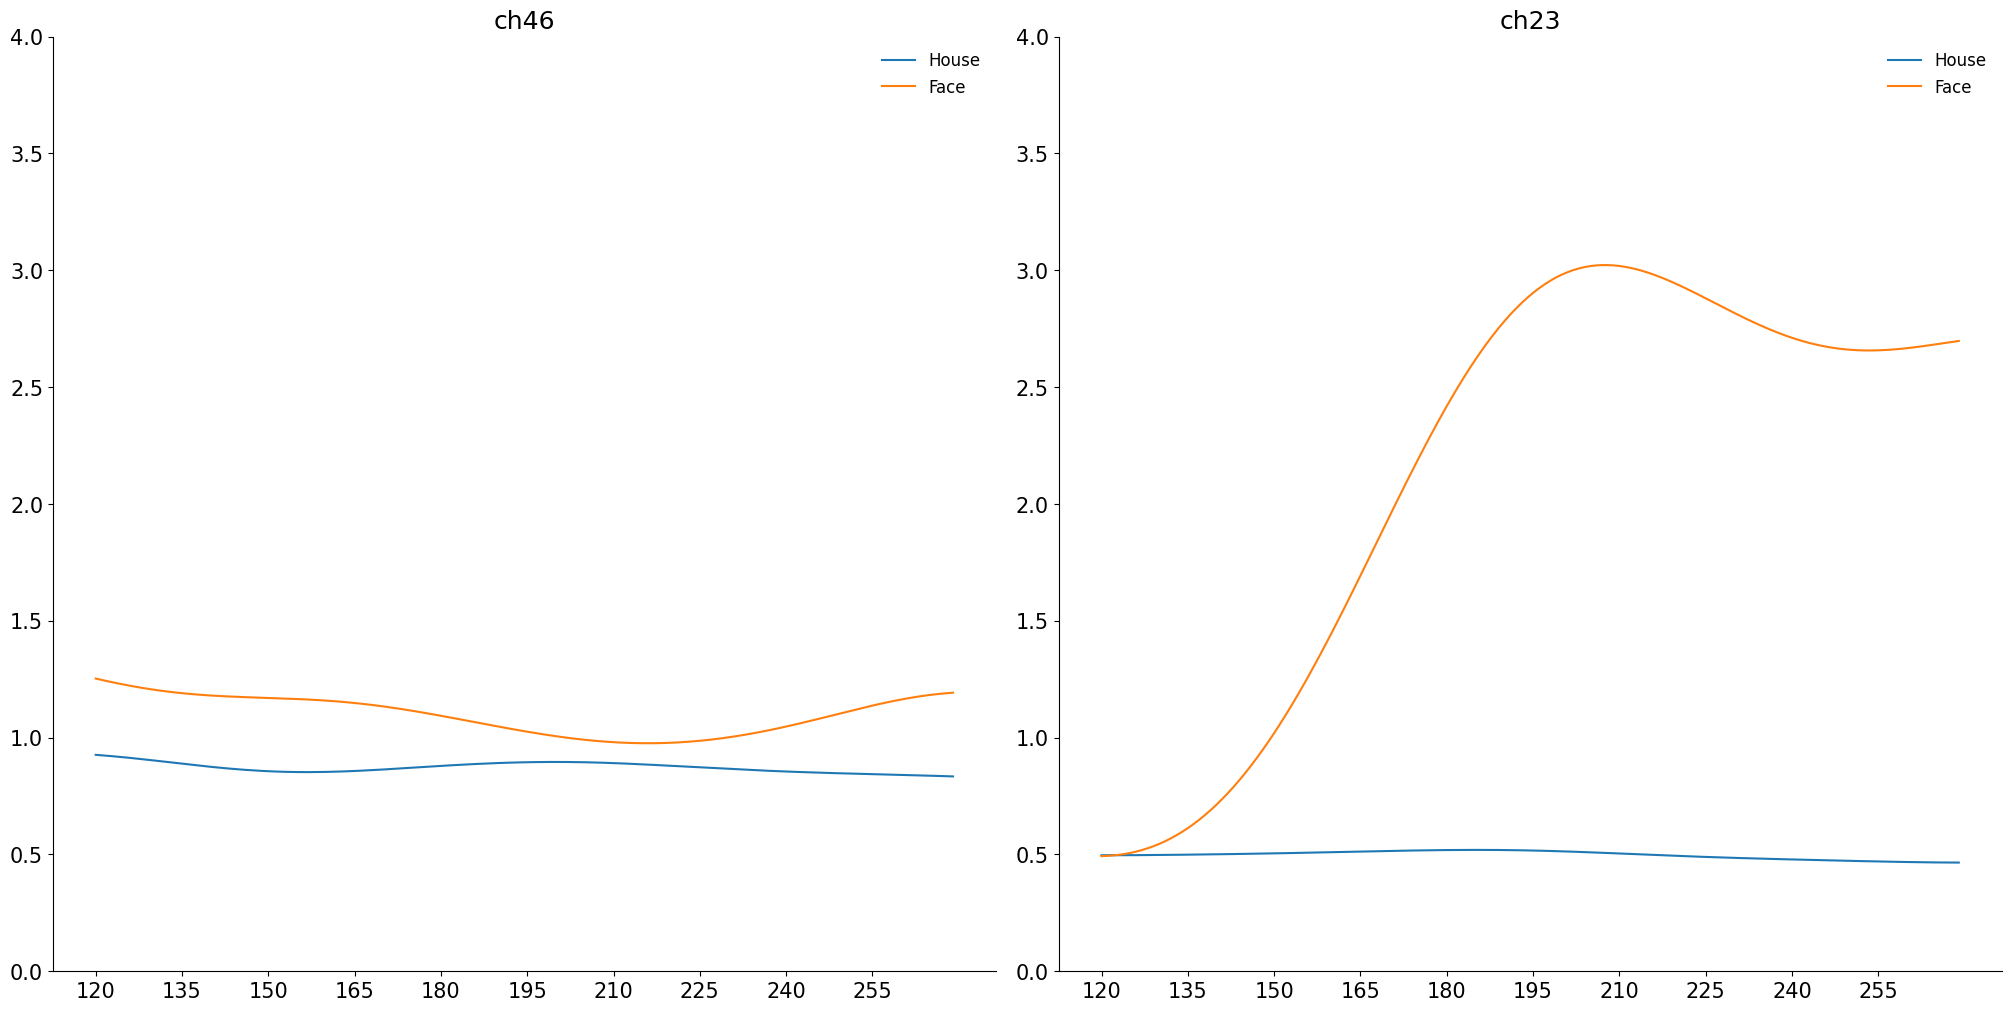

"\nfigure,axs = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)\nax1,ax2=axs\nax1.plot(trange, V_house[:,46],label='house')\nax1.plot(trange, V_face[:, 46],label='face')\nax2.plot(trange, V_house[:,43],label='house')\nax2.plot(trange, V_face[:, 43],label='face')\nax1.set_title('ch46')\nax1.set_xticks(trange_set)\nax1.set_ylim([0, 4])\nax1.legend(loc='upper right', fontsize=6, frameon=False)\nax2.set_title('ch43')\nax2.set_xticks(trange_set)\nax2.set_ylim([0, 4])\nax2.legend(loc='upper right', fontsize=6, frameon=False)\nplt.show()\n"

In [134]:
#更简便的方法
def plot_channel(ax, trange, V_house, V_face, channel, title):
    ax.plot(trange, V_house[:, channel], label='House')
    ax.plot(trange, V_face[:, channel], label='Face')
    ax.set_title(title)
    ax.set_ylim([0, 4])
    ax.legend(loc='upper right', fontsize=12, frameon=False)

figure, axs = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

channels = [46, 23]
titles = ['ch46', 'ch23']

for ax, channel, title in zip(axs, channels, titles):
    plot_channel(ax, trange, V_house, V_face, channel, title)
    ax.set_xticks(trange_set) # 如果 trange_set 是一个合适的范围

plt.show()

"""
figure,axs = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
ax1,ax2=axs
ax1.plot(trange, V_house[:,46],label='house')
ax1.plot(trange, V_face[:, 46],label='face')
ax2.plot(trange, V_house[:,43],label='house')
ax2.plot(trange, V_face[:, 43],label='face')
ax1.set_title('ch46')
ax1.set_xticks(trange_set)
ax1.set_ylim([0, 4])
ax1.legend(loc='upper right', fontsize=6, frameon=False)
ax2.set_title('ch43')
ax2.set_xticks(trange_set)
ax2.set_ylim([0, 4])
ax2.legend(loc='upper right', fontsize=6, frameon=False)
plt.show()
"""

将(120,270)作为时间间隔？

## Step 2: format a selectivity index

## Step 3: responses for noisy data

In [135]:
from scipy import signal
V2 = dat2['V'].astype('float32')

b, a = signal.butter(3, [50], btype='high', fs=1000)
V2 = signal.filtfilt(b, a, V2, 0)
V2 = np.abs(V2)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V2 = signal.filtfilt(b, a, V2, 0)

V2 = V2/V2.mean(0)

In [136]:
nt, nchan = V2.shape
nstim = len(dat2['t_on'])
trange = np.arange(-200, 1000)
ts = dat2['t_on'][:, np.newaxis] + trange
V2_epochs = np.reshape(V2[ts, :], (nstim, 1200, nchan))
stim_cata=dat2['stim_cat'].squeeze()
noise_index=dat2['stim_noise'].squeeze()

In [137]:
#选择噪声...以下的成分,并求第一维的均值
noise_limit=10 #尝试了0.2 0.4 0.6

V2_house_noise=(V2_epochs[(noise_index<=noise_limit)&(stim_cata==1)]).mean(0)
V2_face_noise=(V2_epochs[(noise_index<=noise_limit)&(stim_cata==2)]).mean(0)


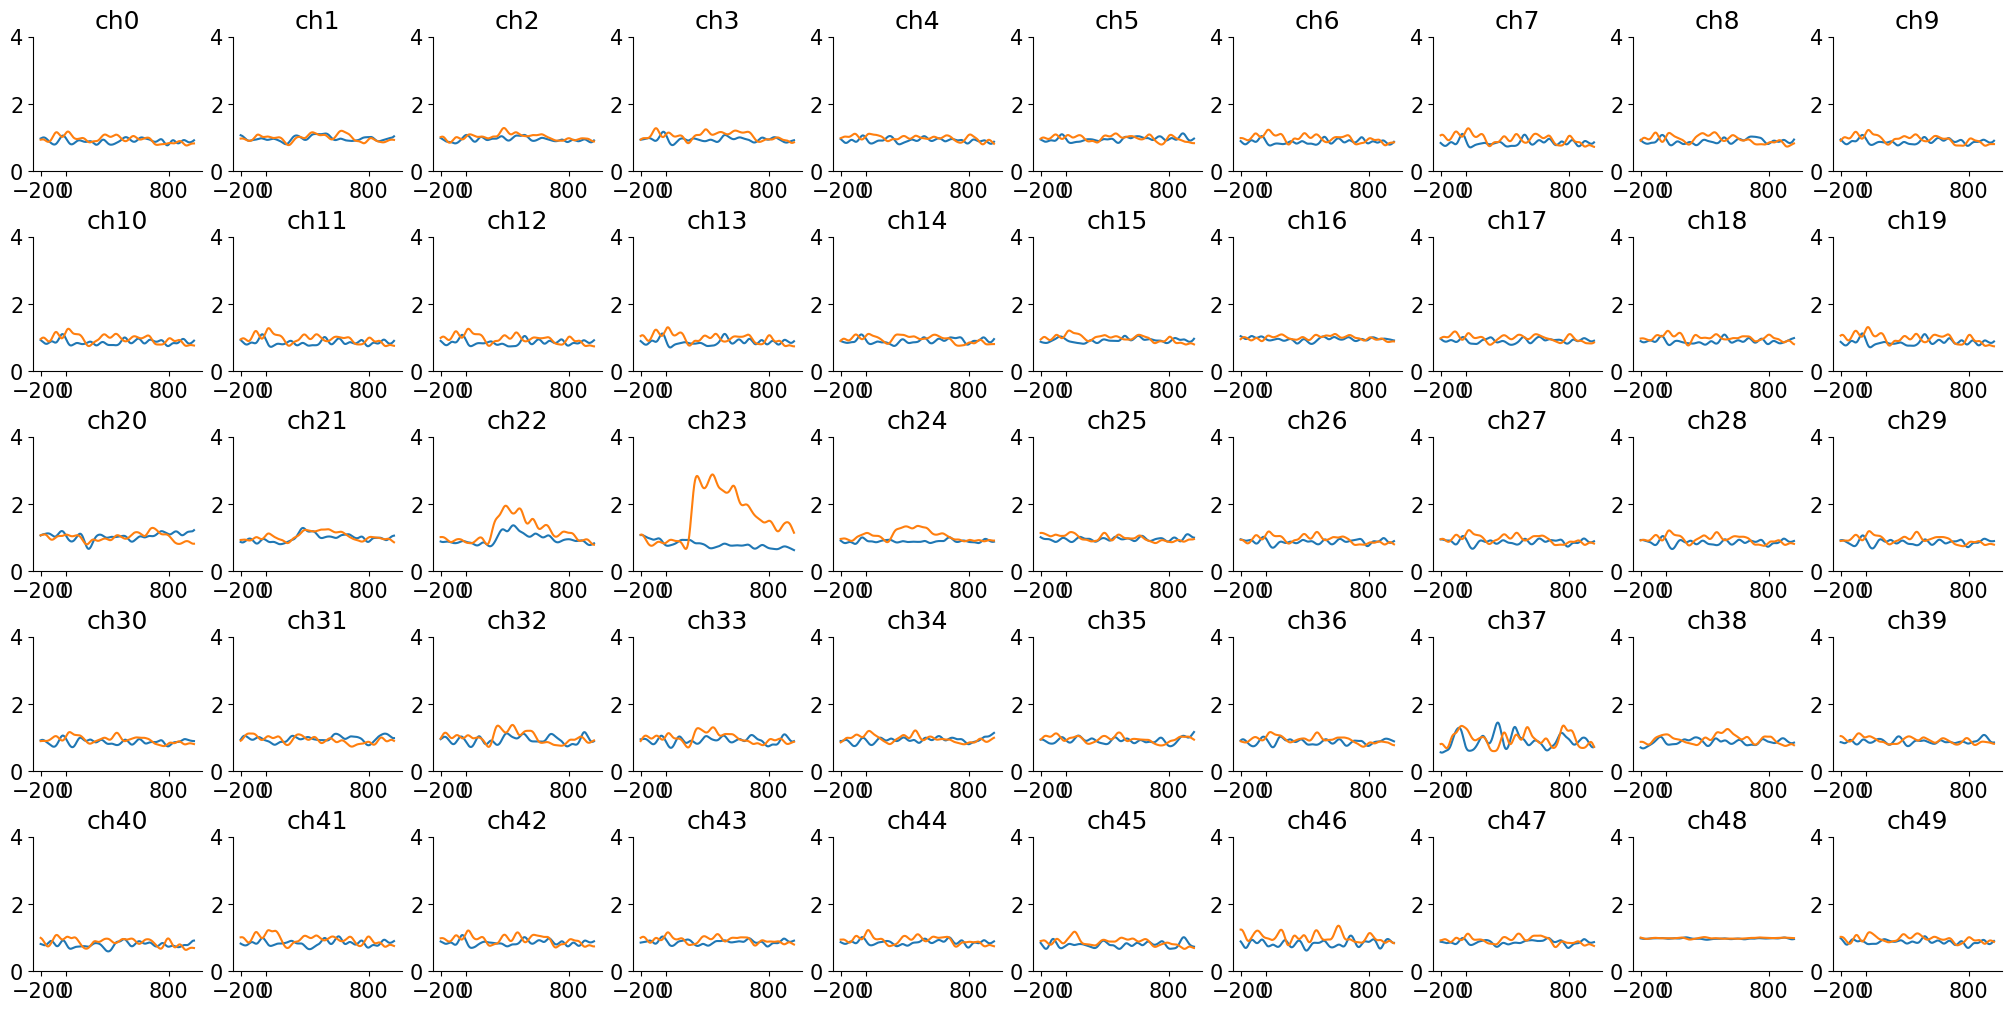

In [138]:
plt.figure(figsize=(20, 10), constrained_layout=True)
for j in range(50):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V2_house_noise[:, j])
  plt.plot(trange, V2_face_noise[:, j])
  plt.title('ch%d'%j)
  plt.xticks([-200, 0, 800])
  plt.ylim([0, 4])
plt.show()

### 23,46号电极的有噪响应

In [139]:
print((V2_epochs[(noise_index==0)&(stim_cata==1)]).shape)#只有15个数据是噪声为0的房屋图片
print((V2_epochs[(noise_index==0)&(stim_cata==2)]).shape)

(15, 1200, 60)
(15, 1200, 60)


**为什么从-200ms开始trange?**  
分析事件相关电位（Event-Related Potentials, ERPs）或其他时间序列数据时，通常会选择一个基线时期作为分析的起始点。这个基线时期通常位于刺激呈现或事件发生的前一段时间。
1. **基线校正**：基线时期可以用于校正或归一化数据，以便在事件发生之前和之后的时间段进行比较。
2. **早期响应分析**：在某些情况下，您可能想要观察事件发生之前的神经活动，以便理解大脑对即将到来的刺激的预期或准备。
3. **与其他试验同步**：如果您正在将这个实验与其他具有类似结构但不同时间戳的实验相比较，同步起始点可以使比较更加合理。

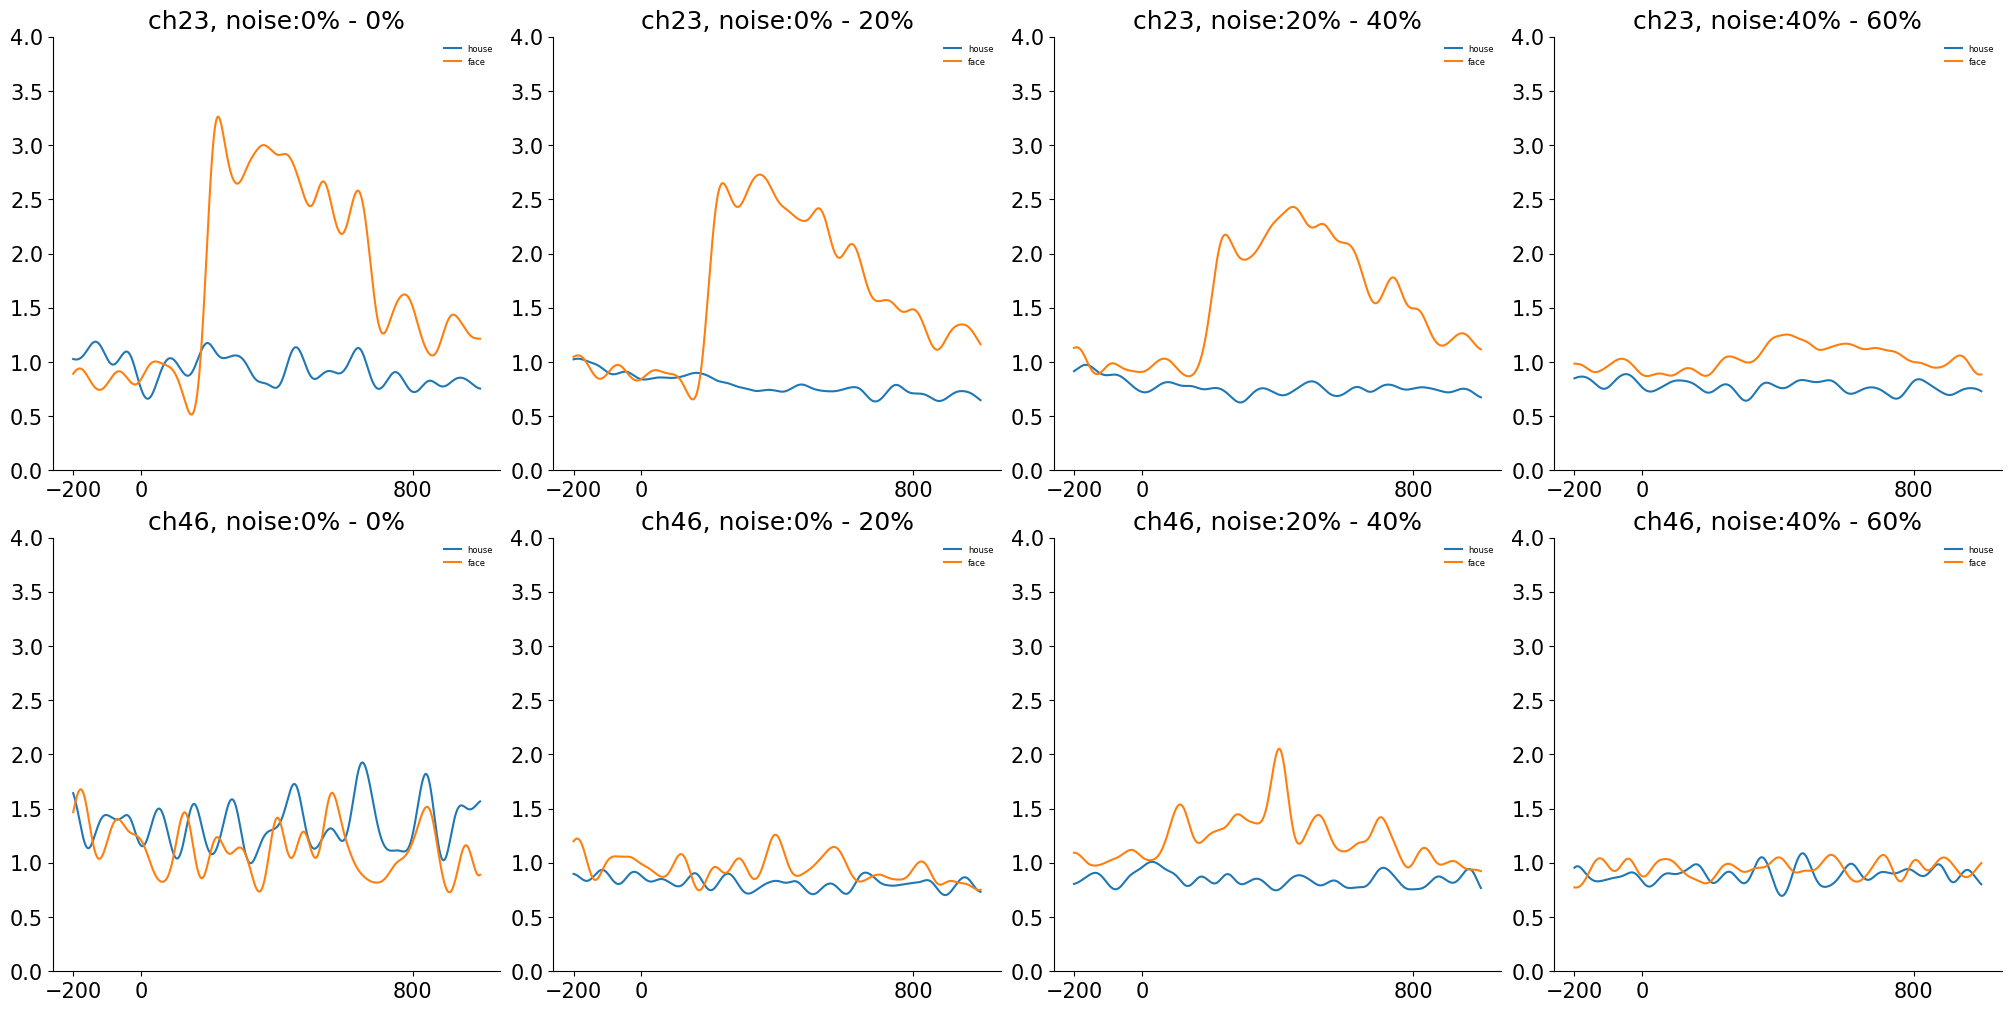

In [140]:
#noise_limit=20 #尝试了0.2 0.4 0.6
noise_array=np.array([0,20,40,60])
#V2_house_noise=(V2_epochs[(noise_index<=noise_limit)&(stim_cata==1)]).mean(0)
#V2_face_noise=(V2_epochs[(noise_index<=noise_limit)&(stim_cata==2)]).mean(0)
fig, axs = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)#准备绘制三行三列子图
for row,ch in enumerate([23,46]):
  for col,noise in enumerate(noise_array):
    ax = axs[row, col]
    noise_min=noise-20
    if noise==0:
      noise_min=0
    #endif
    V2_house_noise = (V2_epochs[((noise_index >= (noise_min)) & (noise_index <= noise)) & (stim_cata == 1)]).mean(0)
    V2_face_noise = (V2_epochs[((noise_index >= (noise_min)) & (noise_index<=noise)) &(stim_cata==2)]).mean(0)
    ax.plot(trange, V2_house_noise[:, ch],label='house')
    ax.plot(trange, V2_face_noise[:, ch],label='face')
    ax.set_title('ch%d, noise:%d%% - %d%%' % (ch, noise_min , noise))
    ax.set_xticks([-200, 0, 800])
    ax.set_ylim([0, 4])
    ax.legend(loc='upper right', fontsize=6, frameon=False)#用于在图表中添加图例

plt.show()

发现46号电极在noise_limit<=20,40,60%都对faces有显著的识别作用,而随着噪声成分增加，43号电极越来越不能分辨面部/房子   
如果将noise_limit==60%，所有电极区域都不具备分辨能力。  
Step 1完成

目标：建立一个[0,1]指数，指数越大，说明电极响应对于人脸/房屋图像的区分度越高  
计算人脸响应/人脸+房屋？（人脸响应在总响应中的占比）

## Step 4: compute TP and FN
psychometric performance

In [141]:

t_on=dat2['t_on']
t_off=dat2['t_off']
key_press=dat2['key_press']
key_cat=np.ones(len(dat2['stim_id']))#初始化为全1数组
print(key_cat.shape)

(630,)
(630,)
(630,)


In [142]:
#key_cat:预测数组
stim_id=dat2['stim_id']
j=0
for i in range(len(stim_id)):
  if (t_on[i]<key_press[j])&(t_off[i]>key_press[j]):
    key_cat[i]=2
    i+=1
    j+=1





In [143]:
#compute TN, FP
from sklearn.metrics import confusion_matrix
label_true=dat2['stim_cat'].squeeze()
label_pred=key_cat

tn, fp, fn, tp = confusion_matrix(label_true, label_pred).ravel()
tp_rate = tp / (tp + fn)
fn_rate = fn / (tp + fn)
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"TP Rate (Recall): {tp_rate}")
print(f"FN Rate: {fn_rate}")

True Positives (TP): 79
False Negatives (FN): 236
TP Rate (Recall): 0.2507936507936508
FN Rate: 0.7492063492063492
